## Modélisation avec RandomForestRegressor pour la prédiction de sales_margin 

# %% Importation des bibliothèques

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np



# %% Chargement des données

In [11]:

file_path = "C:/Users/zineb/OneDrive/Bureau/hetic/DA/silver/data_clean.csv"
df = pd.read_csv(file_path)

In [12]:
df.columns

Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_at', 'close_at', 'close_value', 'sector', 'series',
       'sales_price', 'manager', 'office_location', 'regional_office',
       'year_founded_at', 'revenue', 'number_of_employees'],
      dtype='object')

# %% Préparation des données

In [13]:

# Conversion des colonnes numériques et des dates
df['revenue'] = pd.to_numeric(df['revenue'].str.replace(',', '.', regex=True), errors='coerce')
df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')


# Remplir les valeurs de close_value avec 0 pour les états engaging, prospecting, et lost
df.loc[df['deal_stage'].isin(['engaging', 'prospecting', 'lost']), 'close_value'] = 0


# Calcul des colonnes dérivées
df['sales_margin'] = df.apply(
    lambda row: 0 if row['close_value'] == 0 else row['close_value'] - row['sales_price'], axis=1
)
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days.fillna(0)

# Extraction des informations temporelles
df['engage_month'] = df['engage_at'].dt.month
df['engage_day'] = df['engage_at'].dt.day
df['engage_weekday'] = df['engage_at'].dt.weekday

# Gestion des valeurs manquantes
df.fillna({'sales_margin': 0, 'close_value': 0}, inplace=True)

# Suppression des colonnes non pertinentes
columns_to_drop = ['deal_stage', 'opportunity_id', 'engage_at', 'close_at', 'year_founded_at', 'sales_cycle_days', 'close_value']
df.drop(columns=columns_to_drop, inplace=True)

# Encodage des colonnes catégoriques
label_encoders = {}
cat_columns = ['sales_agent', 'product', 'account', 'sector', 'series', 'manager', 'office_location', 'regional_office']
for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



C:\Users\zineb\AppData\Local\Temp\ipykernel_14808\1971200022.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
C:\Users\zineb\AppData\Local\Temp\ipykernel_14808\1971200022.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')


# %% Séparation des caractéristiques et de la cible

In [14]:

X = df.drop(columns=['sales_margin'])
y = df['sales_margin']

# Normalisation des données numériques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




# %% Division des données

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



# %% Modélisation avec RandomForestRegressor

In [16]:

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

# %% Évaluation du modèle

In [17]:

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")



Mean Absolute Error (MAE): 122.81
Mean Squared Error (MSE): 65304.17
R² Score: -0.1299


# %% Visualisation des importances des caractéristiques

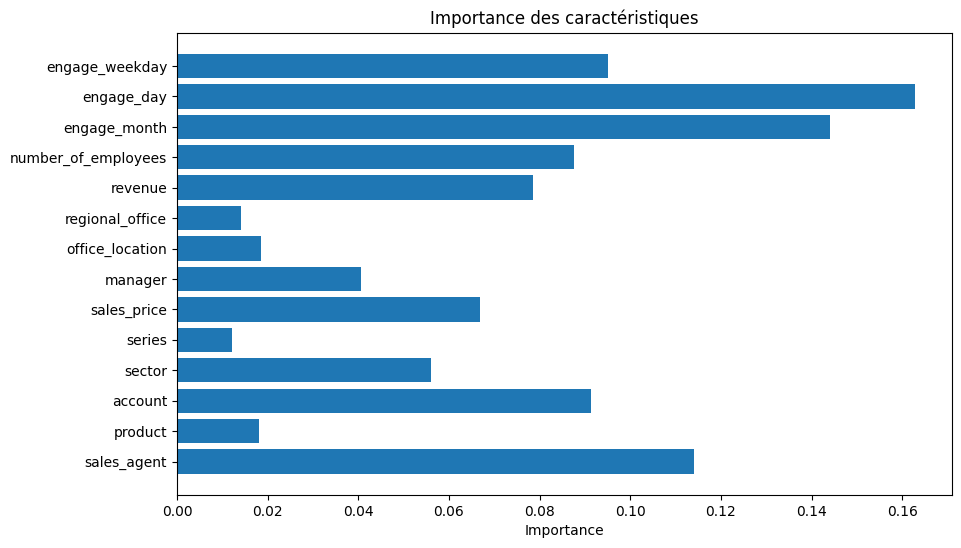

In [18]:

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Importance des caractéristiques")
plt.show()



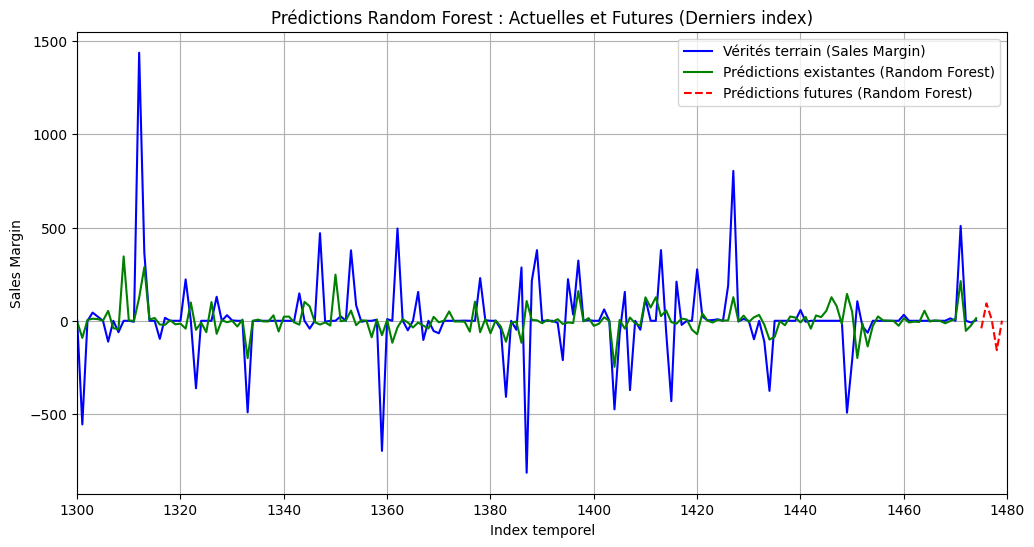

In [19]:
# Données futures simulées
future_data = pd.DataFrame({
    'sales_agent': [27, 29, 11, 15, 6],
    'product': [2, 6, 3, 4, 1],
    'account': [1, 2, 1, 2, 1],
    'sector': [1, 3, 1, 3, 3],
    'series': [1, 1, 2, 3, 1],
    'sales_price': [1096.0, 1096.0, 55.0, 5482.0, 550.0],
    'manager': [3, 5, 1, 2, 4],
    'office_location': [1, 1, 1, 1, 1],
    'regional_office': [1, 2, 0, 2, 2],
    'revenue': [3178.24, 7708.38, 3178.24, 7708.38, 3178.24],
    'number_of_employees': [4540, 13756, 4540, 13756, 4540],
    'engage_month': [8, 11, 2, 9, 3],
    'engage_day': [24, 30, 11, 9, 5],
    'engage_weekday': [1, 2, 2, 3, 3]
})

# Mise à l'échelle des données futures
future_data_scaled = scaler.transform(future_data)
future_predictions = model.predict(future_data_scaled)

# Définir le point de départ pour tracer
start_index = 1300

# Tracer les résultats
plt.figure(figsize=(12, 6))

# Vérités terrain
plt.plot(
    range(start_index, len(y_test)), 
    y_test[start_index:], 
    label="Vérités terrain (Sales Margin)", 
    color="blue"
)

# Prédictions existantes
plt.plot(
    range(start_index, len(y_test)), 
    y_pred[start_index:], 
    label="Prédictions existantes (Random Forest)", 
    color="green"
)

# Prédictions futures
plt.plot(
    range(len(y_test), len(y_test) + len(future_predictions)), 
    future_predictions, 
    label="Prédictions futures (Random Forest)", 
    color="red", 
    linestyle='--'
)

# Ajustements supplémentaires
plt.xlim(start_index, len(y_test) + len(future_predictions))
plt.xlabel("Index temporel")
plt.ylabel("Sales Margin")
plt.title("Prédictions Random Forest : Actuelles et Futures (Derniers index)")
plt.legend()
plt.grid()
plt.show()
